In [1]:
%matplotlib inline
import pydicom
import cv2
import PIL
from PIL import Image as ImagePIL, ImageDraw
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [2]:
# Helper Functions
def apply_ct_window(img, window):
    # window = (window width, window level)
    R = (img-window[1]+0.5*window[0])/window[0]
    R[R<0] = 0
    R[R>1] = 1
    return R

(512, 512)
Image Position [2] of Patient: 160.000002384186mm.


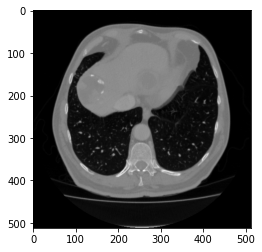

In [3]:
# Opening a DICOM CT Scan Image 
file_path = 'image_100.dcm'
patient_folder = '3Dircadb1.17/PATIENT_DICOM/'
ds = pydicom.read_file(patient_folder + file_path)
pixel_data = ds.pixel_array
print(pixel_data.shape)
img = pixel_data*ds.RescaleSlope + ds.RescaleIntercept
plt.imshow(img, cmap='gray')
print("Image Position [2] of Patient: " + \
      str(ds.ImagePositionPatient[2]) + "mm.")

C:\Users\Radha\Anaconda3.2021\envs\tfgpu36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


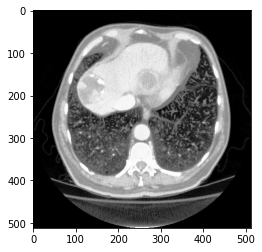

In [17]:
# Creating a copy of the Original Image and converting to RGB, as Overlay for detected contours
photo=np.array(ds.pixel_array)
photo=np.uint8(cv2.normalize(photo, None, 0, 255, cv2.NORM_MINMAX))
photo=cv2.equalizeHist(photo)
image_new=PIL.Image.frombytes('L',
                          (photo.shape[1],photo.shape[0]), photo.astype('b').tostring())
image_new=np.asarray(image_new)
image_new = ImagePIL.fromarray((image_new).astype('uint8'))
image_new = image_new.convert('RGB')
image_new = np.asarray(image_new)
plt.imshow(image_new, cmap='gray')

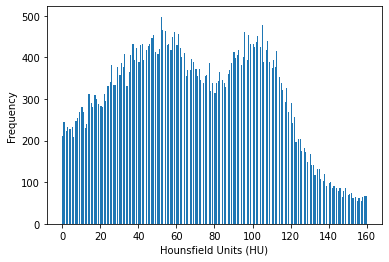

Maximum X = 160.0
Maximum Y = 498.0
X at Y Max =  [51.875]
Mean HU Frequency =  190.70703125
Area =  30513.125


In [18]:
# # Trying to draw some relation to Hounsfield Distribution
y, x, _ = plt.hist(img.ravel(), bins=256, range=[0, 160])
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.show()
print("Maximum X =", x.max())
print("Maximum Y =", y.max())
print("X at Y Max = ",x[np.where(y == y.max())])
print("Mean HU Frequency = ", y.mean())
print("Area = ", sum(np.diff(x)*y))

In [19]:
# Applying the CT Window to the Image
# Liver Window : https://radiopaedia.org/articles/windowing-ct for [150,30]
# Liver Window : https://pubmed.ncbi.nlm.nih.gov/23706868/ for [150,88]
# Source : https://medium.com/analytics-vidhya/how-to-convert-grayscale-dicom-file-to-rgb-dicom-file-with-python-df86ac055bd

if ds.ImagePositionPatient[2] <= 170:
    display_img = apply_ct_window(img, [150,88]) 
elif ds.ImagePositionPatient[2] > 170:
    display_img = apply_ct_window(img, [150,30]) 

# Converting Windowed Image to RGB
img_bbox = ImagePIL.fromarray((255*display_img).astype('uint8'))
img_bbox = img_bbox.convert('RGB')
img_bbox = np.asarray(img_bbox)

In [20]:
# Gray Image set based on the mean Hounsfield Value
gray = cv2.cvtColor(img_bbox, cv2.COLOR_BGR2GRAY)
if y.mean() < 230:
    gray[gray>210]=0 
elif 230 <= y.mean() < 300:
    gray[gray>190]=0 
elif y.mean() >= 300:
    gray[gray>180]=0

In [21]:
# Image Processing
# Blur
img_blur = cv2.GaussianBlur(gray, (11, 11), 1)
# Thresholding
if y.mean() < 230:
    ret, thresh = cv2.threshold(img_blur, 60, 255,cv2.THRESH_BINARY) 
elif 230 <= y.mean() < 300:
    ret, thresh = cv2.threshold(img_blur, 95, 255,cv2.THRESH_BINARY) 
elif y.mean() >= 300:
     ret, thresh = cv2.threshold(img_blur, 95, 255,cv2.THRESH_BINARY) 
# Dilating
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
dilated = cv2.dilate(thresh, kernel, iterations=1) 
# Morphological Operations
k = np.ones((2,2),np.uint8) # current setting
gradient = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)));


23927.5
1080.5
566.0


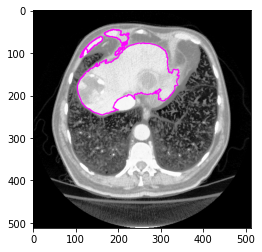

In [22]:
# Detecting Contours
sorted_contours = []
out=image_new.copy()
contours = cv2.findContours(gradient, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)[0]

# Sorting out contours based on area from highest to lower
# Centroid location of organs with respect to Image Centroid
(h, w) = img_bbox.shape[:2]
# compute the center coordinate of the image
(cX, cY) = (w // 2, h // 2)
contours = sorted(contours, key=cv2.contourArea,reverse=True)

# Setting minimum area of contour
if ds.ImagePositionPatient[2] < 10:
    min_contarea = 50
elif ds.ImagePositionPatient[2] > 10:
    min_contarea = 500 


for con in contours:
    if cv2.contourArea(con) > min_contarea:
        epsilon = cv2.arcLength(con,True)
        approx = cv2.approxPolyDP(con,
                              0.001*epsilon, 
                              True)
              
        # If the Centroid of the Contour lies within the top left region then accept
        M = cv2.moments(con)
        if M['m00'] != 0:
            cxx = int(M['m10']/M['m00'])
            cyy = int(M['m01']/M['m00'])
           
                       
        if (0 <= cyy <= cY and 0 <= cxx <= cX) or (0 <= cyy <= cY and cX-40 <= cxx <= cX+40): # to get the central segments
            cv2.drawContours(out, contours=[approx], contourIdx=-1, color=(255, 0, 255), thickness=2) 
            print(cv2.contourArea(con))
            sorted_contours.append(con)

plt.imshow(out, cmap='gray')

 countour area =  23927.5  and aspect ratio =  1.411764705882353
 countour area =  1080.5  and aspect ratio =  0.9516129032258065
 countour area =  566.0  and aspect ratio =  1.08


Text(0.5, 1.0, 'opencv image')

<Figure size 432x288 with 0 Axes>

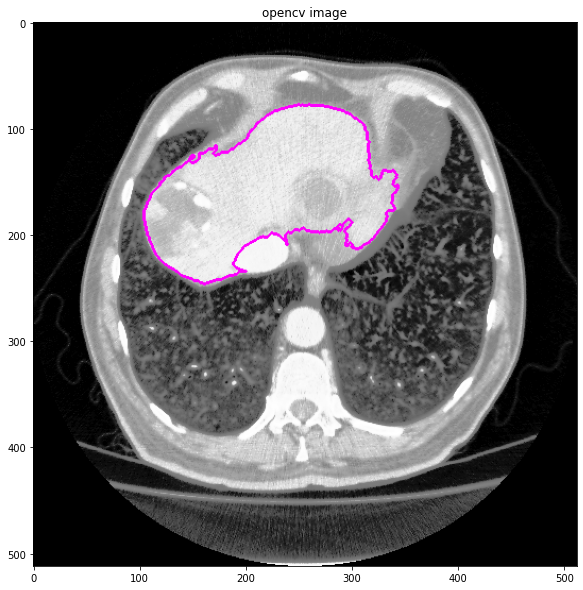

In [24]:
# Draw  the selected contour
selected_contours = []
for con in sorted_contours:
    M = cv2.moments(con)
    if M['m00'] != 0:
        cxx = int(M['m10']/M['m00'])
        cyy = int(M['m01']/M['m00'])
        
    x, y, w, h = cv2.boundingRect(con)
    aspect_ratio = float(w) / h
    print(" countour area = ", cv2.contourArea(con), " and aspect ratio = ",aspect_ratio) 
    
    if ds.ImagePositionPatient[2] < 10 and cxx < 0.5*cX:
        selected_contours.append(con)
    elif 10 <= ds.ImagePositionPatient[2] <= 165:
        selected_contours = sorted_contours[0]
    elif (165 <= ds.ImagePositionPatient[2] <= 170):
        selected_contours.append(sorted_contours[0])
        selected_contours.append(sorted_contours[1])  
    elif (ds.ImagePositionPatient[2] > 170) and (0.5*cX <=cxx < 0.8*cX) and (0.8 <= aspect_ratio < 1.2):
        selected_contours.append(con)

selected_contours = sorted(selected_contours, key=cv2.contourArea,reverse=True)

out1=image_new.copy()

# draw contour on the input image
img_hull = cv2.drawContours(out1, contours=selected_contours, contourIdx=-1, color=(255, 0, 255), thickness=2)
plt.figure(0)
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.imshow(img_hull, cmap='gray')
plt.title("opencv image")